# Simpsons classification

In this project im going to cover the classification problem, using the example of simpsons' dataset.
This notebook was done on kaggle as there is competition on simpsons' classification. You can get the data set there: [Journey to Springfield](https://www.kaggle.com/competitions/journey-springfield/overview)

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import pickle
import numpy as np
import skimage
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import random
import torchvision
import pandas as pd
import seaborn as sns
from torchvision import transforms
from torch.optim import lr_scheduler
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split


from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [5]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
N_CORES = 2
BATCH_SIZE = 640 #128
RESCALE_SIZE = 224
EPOCHS = 20

if torch.cuda.is_available():
    print('CUDA is available! Training on GPU...')
    DEVICE = torch.device("cuda")
else:
    print('CUDA is not available. Training on CPU...')
    DEVICE = torch.device("cpu")

CUDA is available! Training on GPU...


Below we use a wrapper over the dataset for convenient operation. You should understand what is happening with LabelEncoder and with torch.Transformation.

Tittensor converts a PIL Image with parameters in the range [0, 255] (like all pixels) to a FloatTensor of size (C x H x W) [0,1], then scaling is performed:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br> constants - averages and variances across channels based on ImageNet


It is also worth noting that we are redefining the __getitem__ method for the convenience of working with this data structure.
 LabelEncoder is also used to convert string class labels to id and vice versa. The description of the dataset indicates that the pictures are of different sizes, since they were taken directly from the video, so we should bring them to the same size (this is done by the _prepare_sample method)

Below we are constructing the custom dataset with all required preprocessing of the images

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
!cp -r "../input/journey-springfield" "./"

In [9]:
TRAIN_DIR = Path('./journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
len(train_val_files)

20933

In [11]:
len(test_files)

991

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=111)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Let's have a look at some images in the dataset

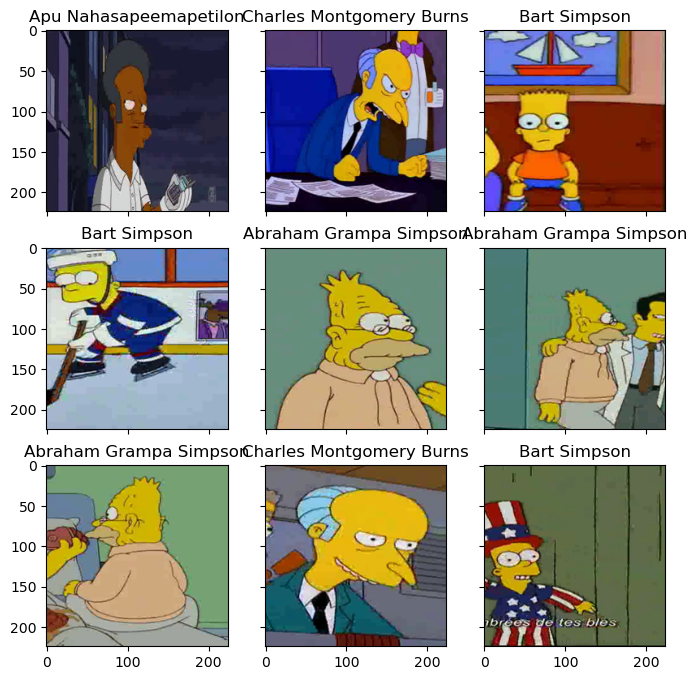

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

### Data augmentation

The data presented is sparse and classes are so imbalanced. So, to deal with the issue it is needed to generate new image for the sake of compensation of the gap among classes

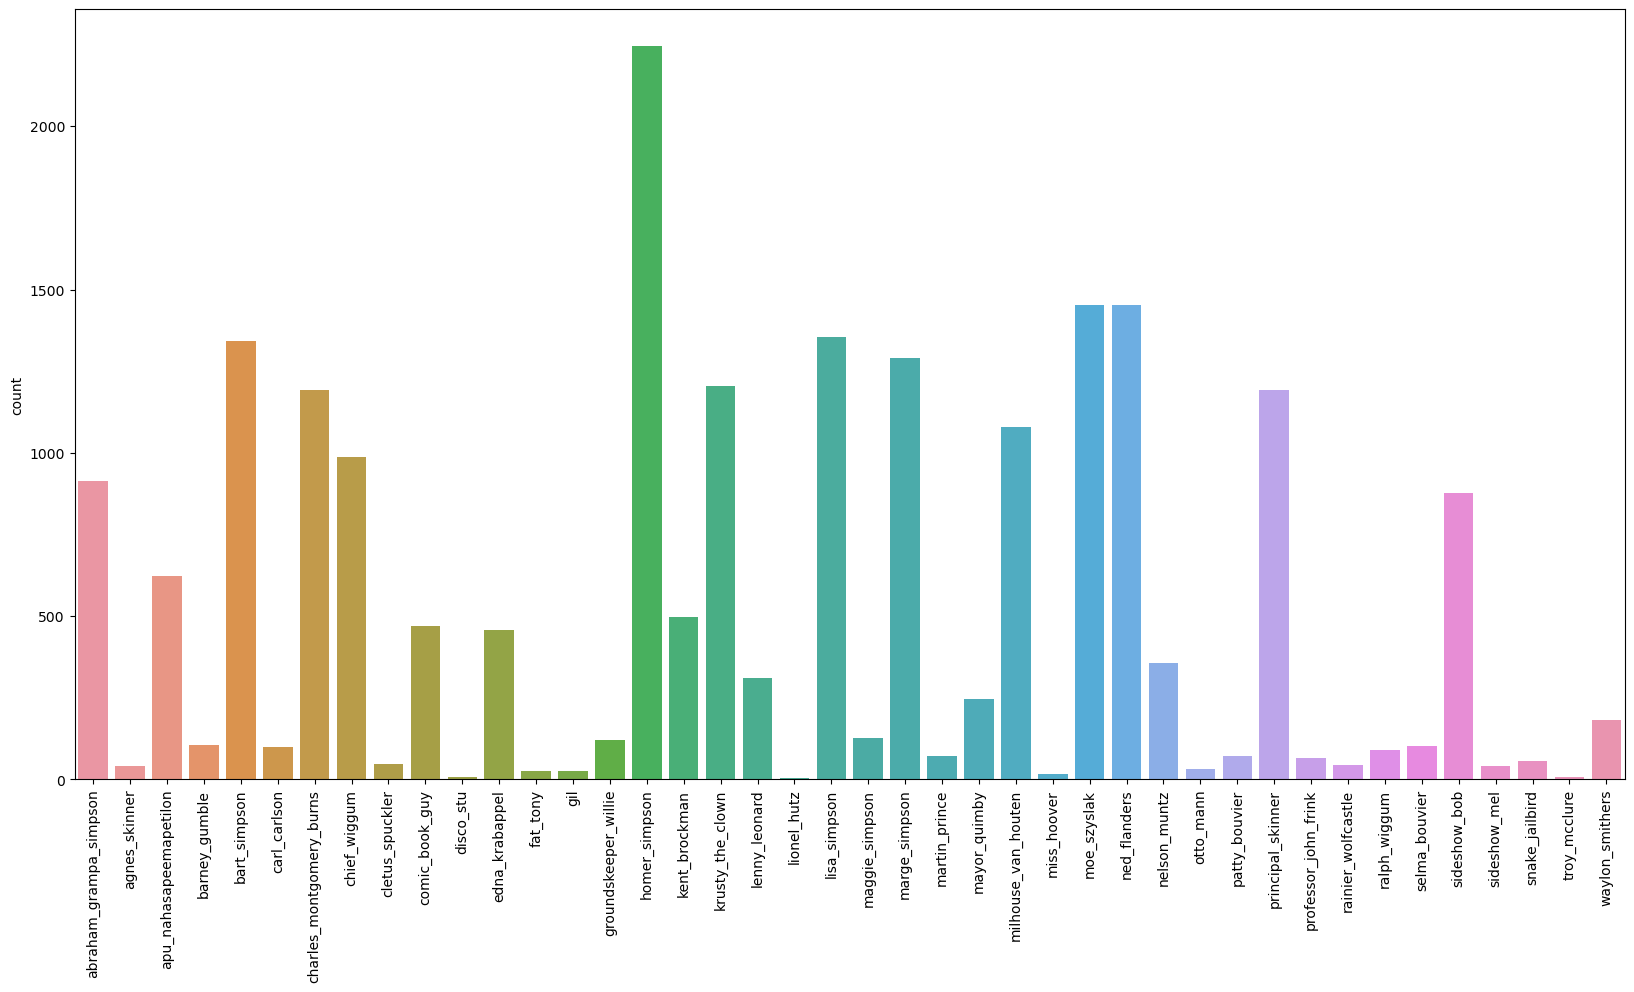

In [15]:
from collections import Counter
data_dict = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
plt.figure(figsize=(20,10))
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.show()

In [16]:
mask = data['count'] < 15000
data.loc[mask, 'to_add'] = (1500 - data['count']).astype(int)
data.loc[~mask, 'to_add'] = 0
data['from_one_img'] = (np.ceil(data['to_add'] / data['count'])).astype(int)

Now i'm about to generate new images via transformation existing ones, to reach better balance between classes

In [17]:
data

,count,to_add,from_one_img
abraham_grampa_simpson,913,587,1
agnes_skinner,42,1458,35
apu_nahasapeemapetilon,623,877,2
barney_gumble,106,1394,14
bart_simpson,1342,158,1
carl_carlson,98,1402,15
charles_montgomery_burns,1193,307,1
chief_wiggum,986,514,1
cletus_spuckler,47,1453,31
comic_book_guy,469,1031,3


In [18]:
augmentations = transforms.RandomChoice([
                                   transforms.Compose([
                                       transforms.Resize(size=313, max_size=333),
                                       transforms.CenterCrop(size=300),
                                       transforms.RandomCrop(250)
                                       ]),
                                   transforms.RandomRotation(degrees=(-33, 33)),
                                   transforms.RandomHorizontalFlip(p=1),
                                   ])
transform = transforms.Compose([
                                    augmentations,
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    transforms.ToPILImage()
                                    ]) 

In [19]:
for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = train_dataset.load_sample(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue
  
    if data.loc[character]['from_one_img'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['from_one_img']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(int(iter_size)):
#         augmenter = random.choice(list(augmenters.values()))
        aug_img = transform(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 15699/15699 [03:53<00:00, 67.32it/s] 


While conducting experiments, it was revealed that it is better to run data augmentation twice

In [20]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
len(train_val_files)

55819

In [21]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, _ = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=111)

train_dataset = SimpsonsDataset(train_files, mode='train')

In [22]:
mask = data['count'] < 15000
data.loc[mask, 'to_add'] = (1500 - data['count']).astype(int)
data.loc[~mask, 'to_add'] = 0
data['from_one_img'] = (np.ceil(data['to_add'] / data['count'])).astype(int)

In [23]:
for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = train_dataset.load_sample(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue
  
    if data.loc[character]['from_one_img'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['from_one_img']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(int(iter_size)):
#         augmenter = random.choice(list(augmenters.values()))
        aug_img = transform(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 41864/41864 [04:08<00:00, 168.66it/s]


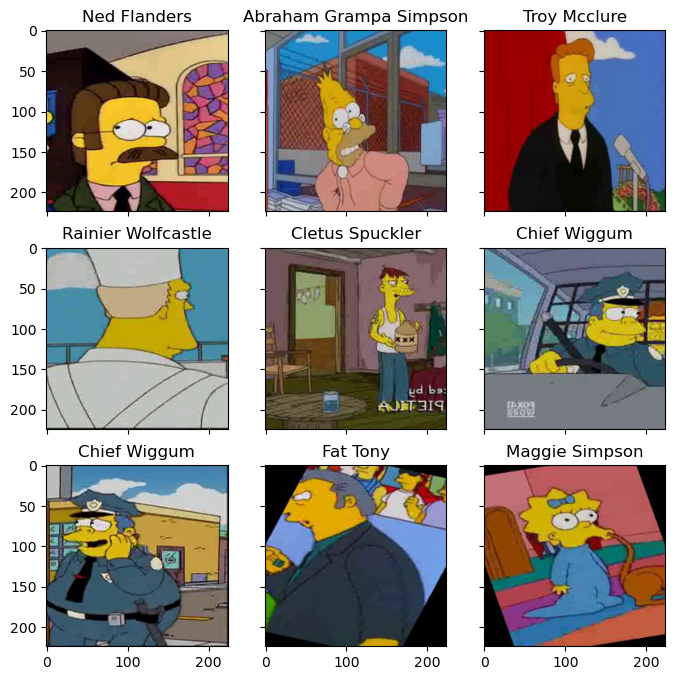

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

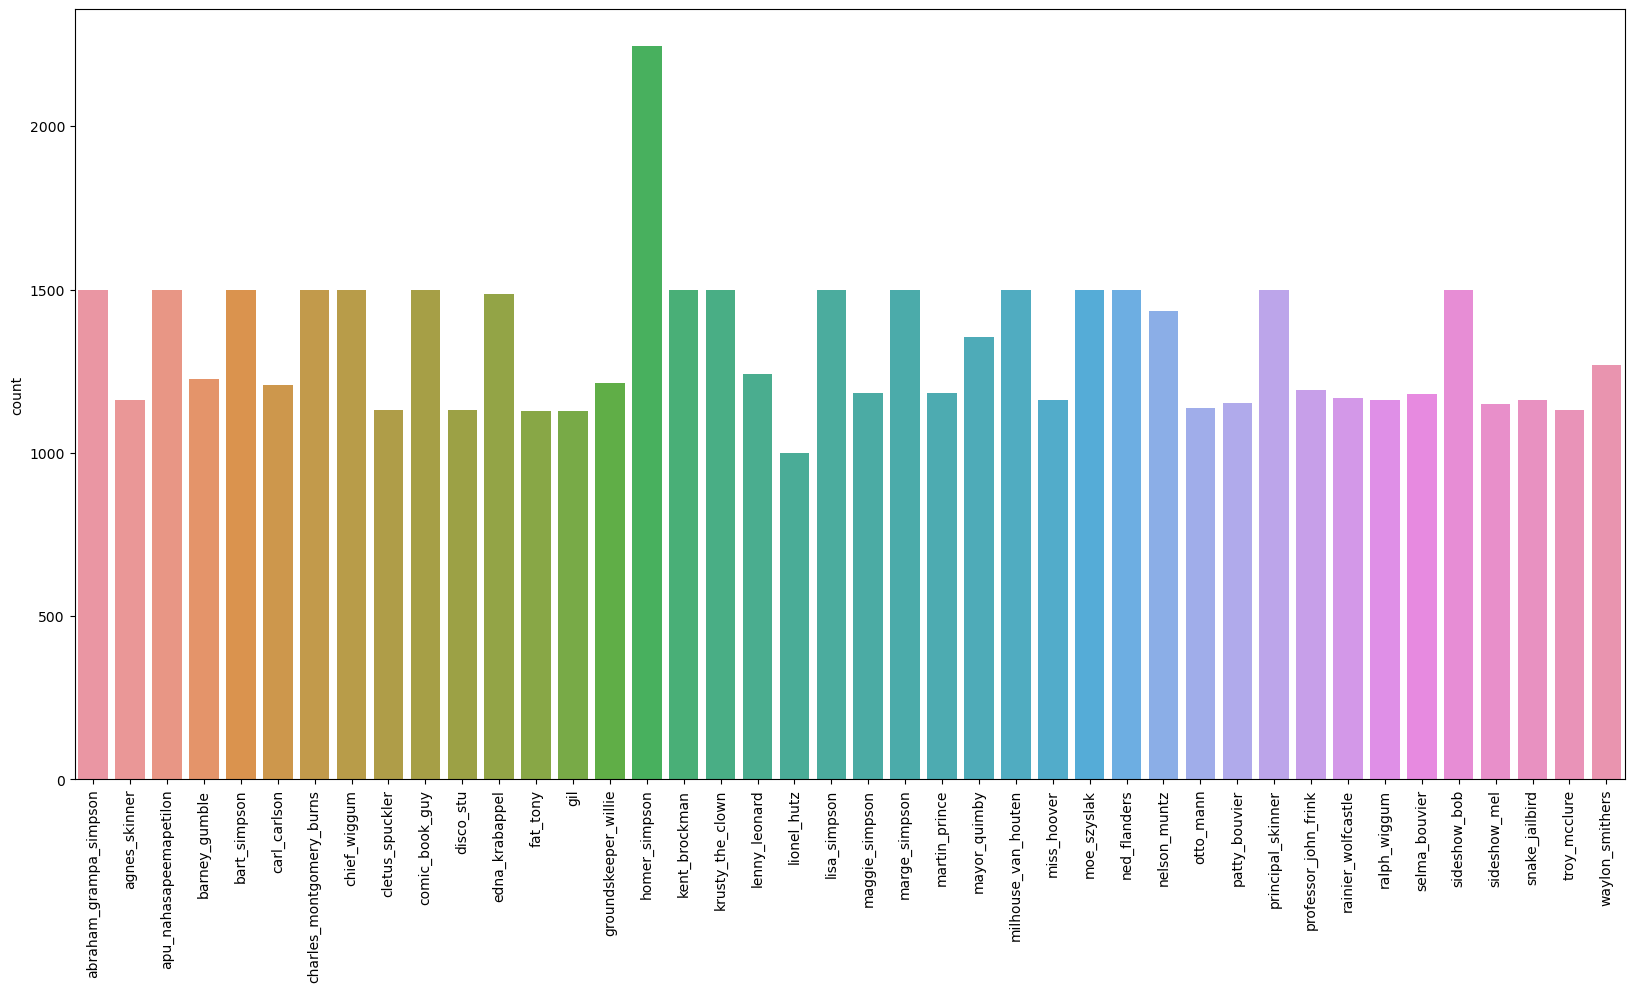

In [25]:
from collections import Counter
data_dict = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
plt.figure(figsize=(20,10))
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.show()

### Building a neural network

Launching this network will be your mini-task for the first week to make it easier to participate in the competition.

This architecture will be very simple and is needed in order to establish a basic understanding and get a simple Kaggle submit

<!-- Here you are invited to add a convolutional network of depth 4/5. -->

*Description of layers*:



1. input dimension: 3x224x224
2.dimensions after the layer: 8x111x111
3. 16x54x54
4. 32x26x26
5. 64 x12 x12
6. output: 96x5x5

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
#             nn.Dropout(0.05),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.linear(x)

#         x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [27]:
def fit_epoch(model, train_loader, criterion, optimizer, DEVICE = DEVICE, scheduler = None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [28]:
def eval_epoch(model, val_loader, criterion, DEVICE = DEVICE):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [29]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [30]:
def predict(model, test_loader,DEVICE = DEVICE):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1)
    return probs

In [31]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [32]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [33]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=16, batch_size=64)

epoch:   0%|          | 0/16 [00:00<?, ?it/s]

loss 1.9848905142055695


epoch:   6%|▋         | 1/16 [03:45<56:29, 225.97s/it]


Epoch 001 train_loss: 1.9849     val_loss 1.4130 train_acc 0.4539 val_acc 0.5888
loss 0.7228680317027264


epoch:  12%|█▎        | 2/16 [07:25<51:52, 222.35s/it]


Epoch 002 train_loss: 0.7229     val_loss 0.7102 train_acc 0.7912 val_acc 0.7887
loss 0.3757396809872081


epoch:  19%|█▉        | 3/16 [11:06<48:03, 221.78s/it]


Epoch 003 train_loss: 0.3757     val_loss 0.5318 train_acc 0.8909 val_acc 0.8449
loss 0.23432439660481552


epoch:  25%|██▌       | 4/16 [14:49<44:23, 221.94s/it]


Epoch 004 train_loss: 0.2343     val_loss 0.4703 train_acc 0.9294 val_acc 0.8703
loss 0.17595703533951876


epoch:  31%|███▏      | 5/16 [18:29<40:36, 221.54s/it]


Epoch 005 train_loss: 0.1760     val_loss 0.3143 train_acc 0.9457 val_acc 0.9131
loss 0.14044112785041798


epoch:  38%|███▊      | 6/16 [22:10<36:50, 221.09s/it]


Epoch 006 train_loss: 0.1404     val_loss 0.3490 train_acc 0.9564 val_acc 0.9106
loss 0.10991164931510275


epoch:  44%|████▍     | 7/16 [25:49<33:05, 220.64s/it]


Epoch 007 train_loss: 0.1099     val_loss 0.2822 train_acc 0.9660 val_acc 0.9348
loss 0.09109733726248392


epoch:  50%|█████     | 8/16 [29:29<29:23, 220.39s/it]


Epoch 008 train_loss: 0.0911     val_loss 0.3244 train_acc 0.9729 val_acc 0.9263
loss 0.08497046138760227


epoch:  56%|█████▋    | 9/16 [33:09<25:42, 220.32s/it]


Epoch 009 train_loss: 0.0850     val_loss 0.2976 train_acc 0.9749 val_acc 0.9366
loss 0.08291255161732139


epoch:  62%|██████▎   | 10/16 [36:50<22:01, 220.29s/it]


Epoch 010 train_loss: 0.0829     val_loss 0.2800 train_acc 0.9754 val_acc 0.9379
loss 0.07051220610045493


epoch:  69%|██████▉   | 11/16 [40:29<18:20, 220.04s/it]


Epoch 011 train_loss: 0.0705     val_loss 0.3524 train_acc 0.9796 val_acc 0.9324
loss 0.06625444190711931


epoch:  75%|███████▌  | 12/16 [43:55<14:23, 215.83s/it]


Epoch 012 train_loss: 0.0663     val_loss 0.3044 train_acc 0.9813 val_acc 0.9394
loss 0.06711509011906795


epoch:  81%|████████▏ | 13/16 [47:22<10:38, 212.93s/it]


Epoch 013 train_loss: 0.0671     val_loss 0.3020 train_acc 0.9813 val_acc 0.9457
loss 0.05841124511280088


epoch:  88%|████████▊ | 14/16 [50:47<07:01, 210.55s/it]


Epoch 014 train_loss: 0.0584     val_loss 0.2921 train_acc 0.9832 val_acc 0.9423
loss 0.05072340540829809


epoch:  94%|█████████▍| 15/16 [54:14<03:29, 209.71s/it]


Epoch 015 train_loss: 0.0507     val_loss 0.3108 train_acc 0.9852 val_acc 0.9438
loss 0.0628896278551257


epoch: 100%|██████████| 16/16 [57:43<00:00, 216.47s/it]


Epoch 016 train_loss: 0.0629     val_loss 0.3650 train_acc 0.9826 val_acc 0.9347


Let's construct the graph of losses on training and validating datasets

In [34]:
loss, acc, val_loss, val_acc = zip(*history)

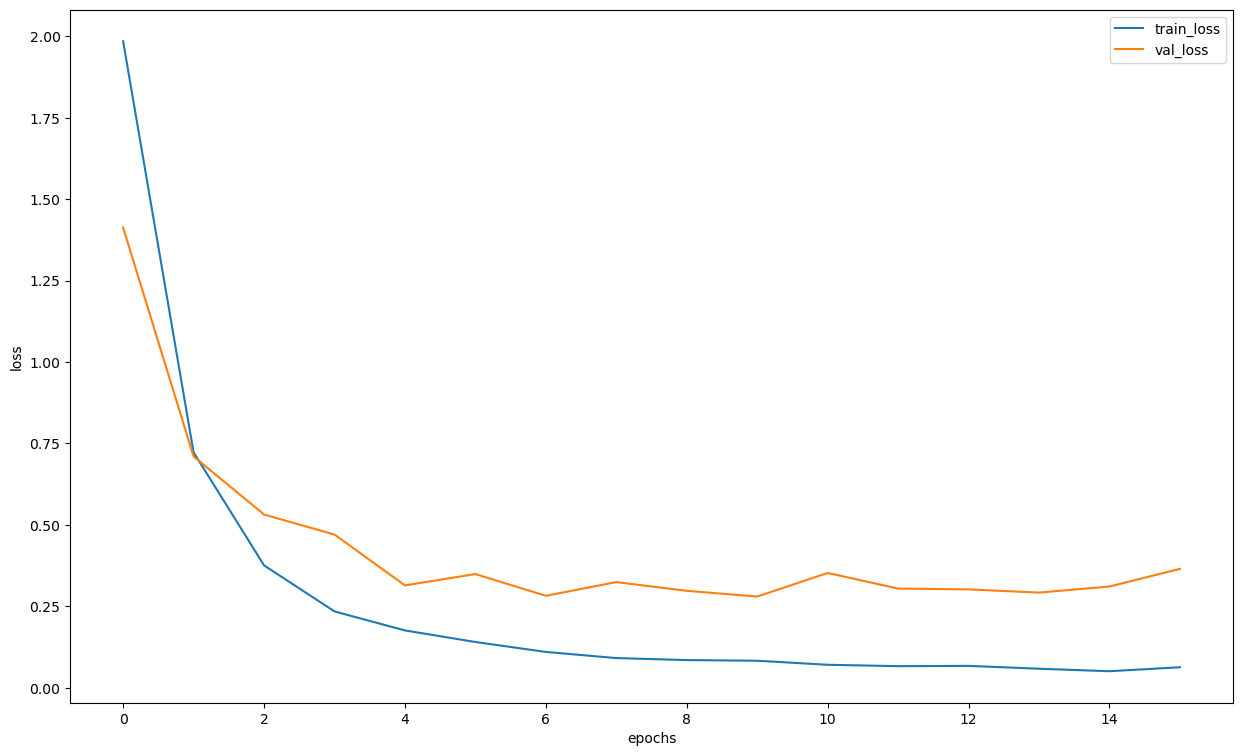

In [35]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### So what is next?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

It would be nice to understand how to make a submission.
We have a network and eval methods for it, which allow us to put the network into prediction mode. It should be understood that our model has softmax on the last layer, which allows you to get a vector of probabilities that an object belongs to a particular class. Let's take advantage of this.

In [36]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [37]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [38]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [40]:
preds = np.array(np.argmax(probs_ims,-1))
y_pred = np.array(list(map(lambda x: int(x), preds)))

actual_labels = np.array([val_dataset[id][1] for id in idxs])

# preds_class = [label_encoder.classes_[i] for i in y_pred]

In [41]:
type(actual_labels[0])

numpy.int64

In [42]:
type(y_pred[0])

numpy.int64

Please note that the metric that needs to be optimized in the competition is-- f1-score. Let's calculate the target metric on the validation sample.

In [43]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average = 'weighted')

0.9727272727272727

Let's make a cool visualization to see how confident the network is in its answers. You can use this to debug the correctness of the output.

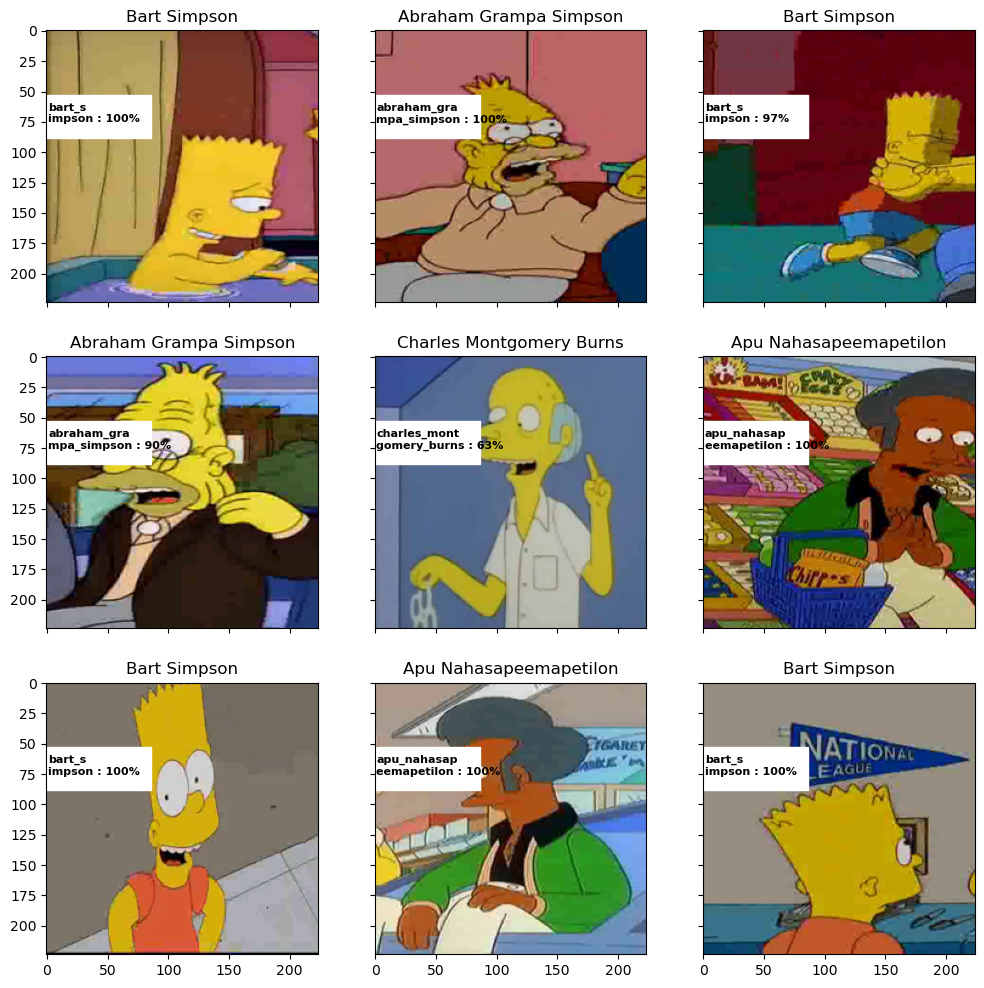

In [44]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle


![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [45]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [46]:
! ls 

__notebook_source__.ipynb  journey-springfield	label_encoder.pkl


In [47]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [48]:
my_submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [49]:
my_submit.to_csv('/kaggle/working/submit.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
